In [141]:
import pandas as pd
import numpy as np

I've been reading the book [Doing Bayesian Data Analysis](https://www.amazon.com/Doing-Bayesian-Data-Analysis-Tutorial/dp/0124058884), and there is an example there with baseball, which I'd like to try for football.

Basically, we want to estimate what's the probability of a player scoring in a match, and which part of that probability is influenced by their position on the field vs other factors. We'll focus on Neymar but I'm actually analysing all players from UEFA Champions League.

First let's load our data. I collected data from UEFA Champions League for 2018 and 2019-2020, each row is a participation of a player in a match, with which position they were on this match, and how much goals they scored. Players that were in substitution bench during the match but never entered the field are not included

In [151]:
df = pd.read_csv("uefa_player_matches.csv", parse_dates=["match_date"])
df = df.dropna()
df = df[df['position'].isin(["G", "D", "M", "F"])] # excluded "SUB" and "-" positions
position_map = {'G': 'Goalkeeper', 'D': 'Defender', 'M': 'Midfield', 'F': 'Forward'}
df['position'] = [ position_map[x] for x in df['position'] ]
df.head()

,match_id,match_date,player,player_id,team,team_id,position,goals
0,158963,2019-06-25 13:00:00+00:00,Mattia Migani,80722.0,Tre Penne,700,Goalkeeper,0
1,158963,2019-06-25 13:00:00+00:00,Davide Cesarini,56095.0,Tre Penne,700,Defender,0
4,158963,2019-06-25 13:00:00+00:00,Mirko Palazzi,56099.0,Tre Penne,700,Defender,0
5,158963,2019-06-25 13:00:00+00:00,Nicola Gai,80723.0,Tre Penne,700,Midfield,0
7,158963,2019-06-25 13:00:00+00:00,Nicola Chiaruzzi,80724.0,Tre Penne,700,Midfield,0


Just to help us understand our data a bit, what's the distribution of goals per match?

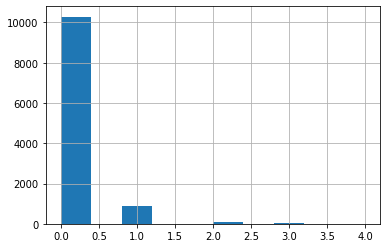

In [150]:
df['goals'].hist();

Woah a Poisson distribution as expected, I love those. Okay and which positions scores more?

In [43]:
df[['position', 'goals']].groupby('position').sum()

,goals
position,
Defender,135
Forward,587
Goalkeeper,3
Midfield,449


Alright zero surprises so far. Let's move on and build a Logistic Regression model, which will give us a probability of a goal given a player and their position.

In [103]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder

X = df[['player_id', 'position']]
one_hot_encoder = OneHotEncoder()
one_hot_encoder.fit(X)
X = one_hot_encoder.transform(X)

y = [ 1 if y > 0 else 0 for y in df['goals'] ]

model = LogisticRegression()
model.fit(X, y)
model.score(X, y)

0.9107711354793067

Logistic regression can fit our data with 91% accuracy, seems pretty good. Now let's take a look on what's the probability of Neymar scoring a goal in some future match:

$$
P(goal | neymar,forward )
$$

In [154]:
neymar_id = 276
X_example = one_hot_encoder.transform([[ neymar_id, "Forward" ]])
model.predict_proba(X_example)[0][1]

0.3835193670312905

38%, not bad, what if Neymar were a Midfield player instead of Forward?

$$
P(goal | neymar,midfield )
$$

In [105]:
X_example = one_hot_encoder.transform([[ neymar_id, "Midfield" ]])
model.predict_proba(X_example)[0][1]

0.2424111808266389

24%, is it good? Is it above average? I think so, but let's check what's the average of player in this positions scoring at all. For that we will take the average of probabilities of all players in that position

$$
P(goal|midfield) = \frac{\sum_{i = 1}^{\#players}{P(goal|players_i,midfield)}}{\#players}
$$

In [149]:
def prob_for_position(position):
    X_example = []
    for player_id in df[df["position"] == position]['player_id'].unique():
        X_example.append([ player_id, position ])
    X_example = one_hot_encoder.transform(X_example)
    ys_pred = [ y[1] for y in model.predict_proba(X_example) ]
    return np.mean(ys_pred)

print("Forward position", prob_for_position("Forward"))
print("Midfield position", prob_for_position("Midfield"))

Forward position 0.165252941308293
Midfield position 0.08585727912713484


Yes, way above average, as an average forward would score with 17% chance (rouding up). It seems that being Neymar puts a hell lot of weight in the probability to score in a match. 

Remember: this doesn't really mean that Neymar the person alone is way better than everybody else, because many other variables such as "Playing in PSG with good team members" are agregated in "being Neymar", as it's not really possible for us to deconfound this variable right now. On the other hand the position variable (forward, midfield) is pretty much deconfounded as we measure accross all players

What about Messi?

$$
P(goal | messi,forward )
$$

In [155]:
messi_id = 154
X_example = one_hot_encoder.transform([[ messi_id, "Forward" ]])
model.predict_proba(X_example)[0][1]

0.4195239138892001

Seems like Messi has a bit higher probability of scoring than Neymar, 42% vs 38%

# Measuring uncertainty with Bayesian Analysis

First let's just see the chances of scoring based on category alone

In [251]:
import pymc3 as pm
import theano.tensor as tt
import theano

positions = list(df['position'].unique())
positions_index = list(range(0, len(positions_names)))
df['position_index'] = [ positions.index(x) for x in df['position'] ]
# with pm.Model():
#     positions_p = {}
#     for position in positions:
#         positions_p[position] = pm.Uniform('position_' + position, lower=0, upper=1)
#         goals = [ 1 if x > 0 else 0 for x in df[df['position'] == position]['goals'] ]
#         pm.Bernoulli('scored_' + position, positions_p[position], observed=goals)

#     trace = pm.sample(1000)
# scores_at_position = [ positions.index(row['position']) for index, row in df.iterrows() ]
with pm.Model():
    positions_p = pm.Uniform('position', lower=0, upper=1, shape=len(positions))
    
#     position_for_goals = tt.vector('position_for_goals')
#     for i, x in enumerate(df['position_index']):
#         tt.set_subtensor(position_for_goals[:i], positions_p[x])
        
    position_for_goals = [ positions_p[x] for x in df['position_index'] ]
#     print("position_for_goalsaaaaaaaaaaaaaaaaaaaaaaaa", position_for_goals)

    goals = [ 1 if x > 0 else 0 for x in df['goals'] ]
    scored = pm.Bernoulli('scored', p=positions_p, observed=goals)

    trace = pm.sample(1000)

ValueError: Input dimension mis-match. (input[0].shape[0] = 11308, input[1].shape[0] = 4)

/Users/rchaves/.pyenv/versions/3.7.8/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


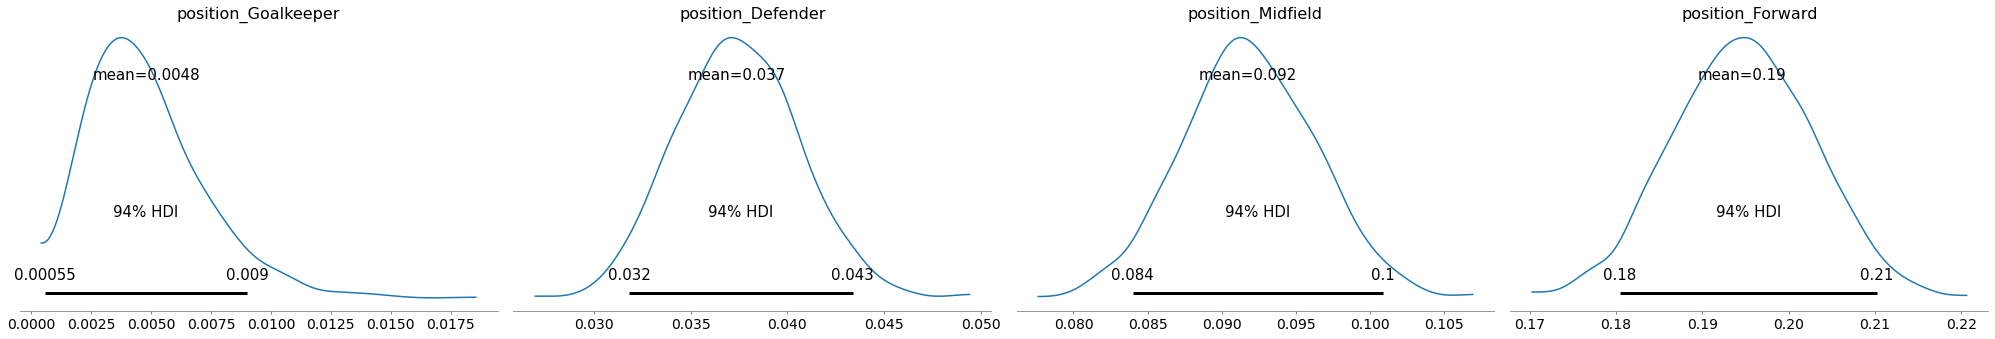

In [190]:
pm.plot_posterior(trace);

The mean score probability for forward position is at 0.19, close to the 0.17 above, and midfield position is at 0.092, close to the 0.085 above

In [204]:
players_most_common_positions = (
    df[['player_id', 'position']]
    .groupby('player_id')
    .agg(lambda x: x.value_counts().index[0])
    .to_dict()['position']
)
players_most_common_positions[neymar_id]

'Forward'

In [209]:
import pymc3 as pm

positions = df['position'].unique()
player_ids = df['player_id'].unique()[0:50]

model = pm.Model()
with model:
    positions_p = {}
    for position in positions:
        positions_p[position] = pm.Uniform('position_' + position, lower=0, upper=1)
    
    for player_id in player_ids:
        position = players_most_common_positions[player_id]
        position_p = positions_p[position]
        
        player_chance = pm.Uniform('player_%s' % player_id, lower=0, upper=1)
        player_at_position_chance = pm.Deterministic("player_plus_position_chance_%s" % player_id, position_p + player_chance)
        
        goals = [ 1 if x > 0 else 0 for x in df[df['player_id'] == player_id]['goals'] ]
        pm.Bernoulli('scored_%s' % player_id, player_at_position_chance, observed=goals)

    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [player_105500.0, player_42988.0, player_42979.0, player_22154.0, player_2242.0, player_2248.0, player_2246.0, player_2234.0, player_2239.0, player_2794.0, player_2232.0, player_2229.0, player_2226.0, player_2228.0, player_2230.0, player_2220.0, player_91621.0, player_55942.0, player_91623.0, player_91620.0, player_91619.0, player_55926.0, player_91618.0, player_55927.0, player_91617.0, player_93139.0, player_74508.0, player_92109.0, player_91614.0, player_91616.0, player_113566.0, player_74513.0, player_91615.0, player_74604.0, player_113565.0, player_74514.0, player_74594.0, player_5080.0, player_5066.0, player_56051.0, player_5065.0, player_5056.0, player_5059.0, player_80726.0, player_80725.0, player_80724.0, player_80723.0, player_56099.0, player_56095.0, player_80722.0, position_Forward, position_Midfield, position_Defender, position_Goalkeeper]


Bad initial energy, check any log probabilities that are inf or -inf, nan or very small:
scored_80722.0    -inf
scored_56095.0    -inf
scored_56099.0    -inf
scored_80723.0    -inf
scored_80724.0    -inf
scored_80725.0    -inf
scored_80726.0    -inf
scored_5059.0     -inf
scored_5056.0     -inf
scored_5065.0     -inf
scored_56051.0    -inf
scored_5066.0     -inf
scored_5080.0     -inf
scored_74594.0    -inf
scored_74514.0    -inf
scored_113565.0   -inf
scored_74604.0    -inf
scored_91615.0    -inf
scored_74513.0    -inf
scored_113566.0   -inf
scored_91616.0    -inf
scored_91614.0    -inf
scored_92109.0    -inf
scored_74508.0    -inf
scored_93139.0    -inf
scored_91617.0    -inf
scored_55927.0    -inf
scored_91618.0    -inf
scored_55926.0    -inf
scored_91619.0    -inf
scored_91620.0    -inf
scored_91623.0    -inf
scored_55942.0    -inf
scored_91621.0    -inf
scored_2220.0     -inf
scored_2230.0     -inf
scored_2228.0     -inf
scored_2226.0     -inf
scored_2229.0     -inf
scored_2232.0 

ParallelSamplingError: Bad initial energy

In [210]:
for RV in model.basic_RVs:
    print(RV.name, RV.logp(model.test_point))

position_Goalkeeper_interval__ -1.3862943611198906
position_Defender_interval__ -1.3862943611198906
position_Midfield_interval__ -1.3862943611198906
position_Forward_interval__ -1.3862943611198906
player_80722.0_interval__ -1.3862943611198906
player_56095.0_interval__ -1.3862943611198906
player_56099.0_interval__ -1.3862943611198906
player_80723.0_interval__ -1.3862943611198906
player_80724.0_interval__ -1.3862943611198906
player_80725.0_interval__ -1.3862943611198906
player_80726.0_interval__ -1.3862943611198906
player_5059.0_interval__ -1.3862943611198906
player_5056.0_interval__ -1.3862943611198906
player_5065.0_interval__ -1.3862943611198906
player_56051.0_interval__ -1.3862943611198906
player_5066.0_interval__ -1.3862943611198906
player_5080.0_interval__ -1.3862943611198906
player_74594.0_interval__ -1.3862943611198906
player_74514.0_interval__ -1.3862943611198906
player_113565.0_interval__ -1.3862943611198906
player_74604.0_interval__ -1.3862943611198906
player_91615.0_interval__

In [ ]:
pm.plot_posterior(trace);